# Speech Denoising Using Deep Learning

In [36]:
import librosa 
import numpy as np

# Reading the training file
s, sr=librosa.load('data/train_clean_male.wav', sr=None) 
S_input=librosa.stft(s, n_fft=1024, hop_length=512)

sn, sr=librosa.load('data/train_dirty_male.wav', sr=None) 
X_input=librosa.stft(sn, n_fft=1024, hop_length=512)

# Reading test 01 file
st_01, sr_01=librosa.load('data/test_x_01.wav', sr=None) 
X_test_01=librosa.stft(st_01, n_fft=1024, hop_length=512)

# Reading test 02 file
st_02, sr_02=librosa.load('data/test_x_02.wav', sr=None) 
X_test_02=librosa.stft(st_02, n_fft=1024, hop_length=512)

In [37]:
# Get the magnitudes of training set, and test sets
S_mag = np.abs(S_input).T
X_mag = np.abs(X_input).T
X_test_01_mag = np.abs(X_test_01).T
X_test_02_mag = np.abs(X_test_02).T

In [72]:
# Importing MNIST data 
import tensorflow as tf
import numpy as np

# Learning rate, batch size and number of epochs
alpha = 0.0001
batch_size = 250
epochs = 15000
beta = 0.0000001

# Placeholders for X and Y training 
X = tf.placeholder(tf.float32, [None, 513])
Y = tf.placeholder(tf.float32, [None, 513])

## FORWARD PROPOGATION
# Weights and Biases for hidden layers (2 hidden layers with 1024 hidden units). Using He initialization for W
W1_ = tf.Variable(tf.random_normal([513,1026],stddev=1, seed=np.random.randint(1,1000))*np.sqrt(2/1026), name='w1_') 
b1_ = tf.Variable(tf.zeros([1026]), trainable=True, name="b1_")

W2_ = tf.Variable(tf.random_normal([1026,1026],stddev=1, seed=np.random.randint(1,1000))*np.sqrt(2/1026), name='w2_') 
b2_ = tf.Variable(tf.zeros([1026]), trainable=True, name="b2_")

Wl_ = tf.Variable(tf.random_normal([1026,513],stddev=1, seed=np.random.randint(1,1000))*np.sqrt(2/513), name='wl_') 
bl_ = tf.Variable(tf.zeros([513]), trainable=True, name="bl_")

# Outputs of hidden layers
z1_ = tf.add(tf.matmul(X,W1_), b1_)
a1_ = tf.nn.relu(z1_)

z2_ = tf.add(tf.matmul(a1_,W2_), b2_)
a2_ = tf.nn.relu(z2_)

zl_ = tf.add(tf.matmul(a2_,Wl_), bl_)
al_ = tf.nn.relu(zl_)

y_ = al_ # tf.clip_by_value(al, -0.000000001, 0.99999999)

# Cost as cross huber loss and optimizer
loss_ = tf.losses.huber_loss(labels=Y, predictions=y_) 
regularizers_ = tf.nn.l2_loss(W1_) + tf.nn.l2_loss(W2_) + tf.nn.l2_loss(Wl_) 
loss_ = tf.reduce_mean(loss_ + beta * regularizers_)
optimiser_ = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss_)

_init_ = tf.global_variables_initializer()

epoch_loss = []

with tf.Session() as sess:
    
    # Initialize variables
    
    sess.run(_init_)
    m = len(X_mag)
    num_batches = int(m/batch_size)
    
    print("Number of training samples : ", m)
    print("Number of Epochs : ", epochs)
    print("Number of batches : ", num_batches)
    
    epoch_loss_ = []
    
    # iterate through epochs
    for epoch in range(epochs):
        cost_ = 0.0
        
        # iterate through 
        i = 0
        j = batch_size + 1
        for batch in range(num_batches):
            X_batch = X_mag[i:j]
            Y_batch = S_mag[i:j]
            
            i = j
            j = j + batch_size
            
            _,curr_cost = sess.run([optimiser_, loss_], feed_dict={X: X_batch, Y: Y_batch})
            
            cost_ = cost_ + curr_cost/num_batches
            
            y_hat_train = sess.run(al_, feed_dict={X:X_mag})
            y_hat_test_01 = sess.run(al_, feed_dict={X:X_test_01_mag})
            y_hat_test_02 = sess.run(al_, feed_dict={X:X_test_02_mag})
        
        epoch_loss.append(cost_)
        if epoch % 1000 == 0:
            print("Epoch : ", epoch, "\tCost : ", cost_)
    print("Epoch : ", epoch, "\tCost : ", cost_)

Number of training samples :  2459
Number of Epochs :  15000
Number of batches :  9
Epoch :  0 	Cost :  0.04388542390531963
Epoch :  1000 	Cost :  0.0008949382916196353
Epoch :  2000 	Cost :  0.000575685000512749
Epoch :  3000 	Cost :  0.0004500824434217065
Epoch :  4000 	Cost :  0.0003657602226465113
Epoch :  5000 	Cost :  0.0003404393759814815
Epoch :  6000 	Cost :  0.0002831619931384921
Epoch :  7000 	Cost :  0.00026695921810136904
Epoch :  8000 	Cost :  0.00024261343221749278
Epoch :  9000 	Cost :  0.00020822365574228263
Epoch :  10000 	Cost :  0.00020357288142097078
Epoch :  11000 	Cost :  0.00020352523521675417
Epoch :  12000 	Cost :  0.00019500559978445783
Epoch :  13000 	Cost :  0.00018335577786072265
Epoch :  14000 	Cost :  0.00018920996485071047
Epoch :  14999 	Cost :  0.00018348284356761724


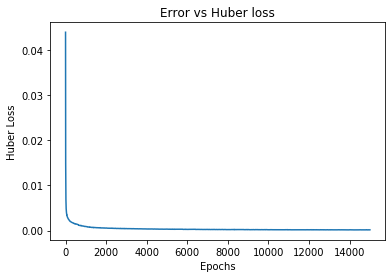

In [73]:
plt.plot([c for c in range(epochs)],epoch_loss)
plt.xlabel("Epochs")
plt.ylabel("Huber Loss")
plt.title("Error vs Huber loss")
plt.show()

For SNR, we will take the RMS value of Magnitudes of Clean and Noisy signals use the below formula:
    
    SNR = 10 * log10( Pc / Pn )
    
    where, Pc is the RMS of clean signal 
           Pn is the RMS of noise
           
           We find the Noise by subtracting the magnitudes of noisy signal with clean signal. 


In [74]:
# Function to calculate SNR 
def snr(clean, dirty):
    return 10 * np.log10(np.mean(np.square(clean))/np.mean(np.square(np.subtract(dirty,clean))))

In [77]:
print('\033[1m' + "Signal to Noise Ratios:\n" + '\033[0m')
print("SNR for the original cleaned audio sample (training) and the output of DNN for the training sample. ")
print("SNR of train_clean_male and y_hat :", snr(S_mag,y_hat_train))
print('\n')
print("SNR for the original noisy audio sample (training) and the output of DNN for the training sample. ")
print("SNR of train_dirty_male and y_hat :", snr(X_mag,y_hat_train))
print('\n')
print("SNR for the original noisy test sample 01 and the output of DNN for the test sample 01. ")
print("SNR of test_x_01 and y_hat :", snr(X_test_01_mag,y_hat_test_01))
print('\n')
print("SNR for the original noisy test sample 02 and the output of DNN for the test sample 02. ")
print("SNR of test_x_02 and y_hat :", snr(X_test_02_mag,y_hat_test_02))

Signal to Noise Ratios:

SNR for the original cleaned audio sample (training) and the output of DNN for the training sample. 
SNR of train_clean_male and y_hat : 22.4324631690979


SNR for the original noisy audio sample (training) and the output of DNN for the training sample. 
SNR of train_dirty_male and y_hat : 7.783761620521545


SNR for the original noisy test sample 01 and the output of DNN for the test sample 01. 
SNR of test_x_01 and y_hat : 8.390052914619446


SNR for the original noisy test sample 02 and the output of DNN for the test sample 02. 
SNR of test_x_02 and y_hat : 9.470822811126709


In [78]:
# Write the outputs to files 

# Recover the (complex-valued) speech spectrogram of the test signal 
s_01 = np.multiply(np.divide(X_test_01,X_test_01_mag.T),y_hat_test_01.T)
s_02 = np.multiply(np.divide(X_test_02,X_test_02_mag.T),y_hat_test_02.T)

# Take inverse-STFT 
out_01 = librosa.istft(s_01, hop_length=512)
out_02 = librosa.istft(s_02, hop_length=512)

# Write the output
librosa.output.write_wav('data/test_s_01_recons.wav', out_01, sr_01)
librosa.output.write_wav('data/test_s_02_recons.wav', out_02, sr_02)

In [79]:
import IPython.display as ipd
ipd.Audio('data/test_s_01_recons.wav')

In [80]:
import IPython.display as ipd
ipd.Audio('data/test_s_02_recons.wav')